In [87]:
from notebook_tools import *
from scipy.optimize import curve_fit
%matplotlib inline

# pp-SRC analysis

In [3]:
target='C12'
columns = ['Q2','theta (miss-q)','Pmiss3Mag','pcmX','pcmY','pcmZ']
data = read_root( path+"/AnaFiles/Ana_ppSRCcut_DATA_%s.root"%target, columns=columns )
# data['pcm'] = np.sqrt(np.square(data['pcmX']) + np.square(data['pcmY']) + np.square(data['pcmZ']))

In [82]:
cm_parameters = pd.read_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/DATA/C12_dataCMparameters.csv')

In [67]:
Pmiss = 0.5*(cm_parameters.pMiss_min + cm_parameters.pMiss_max)
pmiss_bin_width = 0.5*(cm_parameters.pMiss_max - cm_parameters.pMiss_min)

In [156]:
def fit_par_plot( data , var , weight ,
                 PmissOffset = 0,
                 title=None , do_plot_fit_pars=True , fontsize=25, figsize=(20,10)): 
    fig,ax=plt.subplots(figsize=figsize)
    ax.grid(True,linestyle='-',color='0.95')
    p_err = np.zeros(len(pmiss_bin_width))
    [Xfit,XfitErr] = plot_errorbar_and_fit( ax , Pmiss, data[ var + '_x_' + weight] ,
                                           [p_err,p_err] , [data[ var + '_xErr_' + weight ], data[ var + '_xErr_' + weight ]], 
                                           'black','v','none',r'$x-direction$' ,'const',do_plot_fit_pars=do_plot_fit_pars)
    
    [Yfit,YfitErr] = plot_errorbar_and_fit( ax , Pmiss, data[ var + '_y_' + weight] ,
                                           [p_err,p_err] , [data[ var + '_yErr_' + weight ],data[ var + '_yErr_' + weight ]],
                                           'red'  ,'o','none',r'$y-direction$' ,'const',do_plot_fit_pars=do_plot_fit_pars)
    
    [Za1,Za1err],[Za2,Za2err] = plot_errorbar_and_fit( ax=ax , x=Pmiss, x_offset=PmissOffset, y=data[ var + '_z_' + weight] ,
                                                      xerr=[p_err,p_err] , yerr=data[ var + '_zErr_' + weight ],
                                                      color='blue' ,marker='s',lstyle='none',label=r'$\vec{p}_{miss}-direction$' ,fit_type='linear',
                                                      do_plot_fit_pars=do_plot_fit_pars)
    ax.legend(loc='best',fontsize=fontsize)
    set_axes(ax=ax,x_label='$p_{miss}$ [GeV/c]',y_label='c.m. momentum %s [Gev/c]'%title,fontsize=fontsize)

In [162]:
def plot_errorbar_and_fit( ax , x , y , xerr , yerr , color , marker , lstyle , label ,
                          fit_type='const' ,do_plot_fit_pars=False, x_offset=0):
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, color=color, marker=marker , linestyle=lstyle , label=None , markersize=15)

    if fit_type=='const':
        const_fit , const_fitErr = fit_as_a_function_of_pmiss( x , y , yerr , fit_type , title=label)
        if do_plot_fit_pars: label=label + "$=%.3f\pm%.3f$"%(const_fit,const_fitErr)
        ax.plot(x, np.ones(len(x))*const_fit , color=color , linestyle='--', label=label,linewidth = 2 , )
        return [ const_fit , const_fitErr ]
    
    elif fit_type=='linear':
        a1 , a1err , a2 , a2err  = fit_as_a_function_of_pmiss( x , y,  yerr , fit_type , title=label, x_offset=x_offset)
        if do_plot_fit_pars: label=label + "$=(%.3f)(p_{miss}-%.1f)+(%.3f)$"%( a1 , x_offset, a2 )
        ax.plot( x , a1*(x-x_offset) + a2 , color = color ,label=label )
        return [ a1 , a1err] , [ a2 , a2err ]

In [163]:
# define fitting functions
def linear(x, slope, intercept):
    return slope * ( x ) + intercept

def linear_06(x, slope, intercept):
    return slope * ( x - 0.6 ) + intercept


def fit_as_a_function_of_pmiss( x , y , yerr, fit_type='const' , title='', x_offset=0 ):
    if fit_type=='const':
        p1,v1 = np.polyfit( x , y , 0 , cov=True)
        print 'const fit (%s) parameters:\n'%title,p1,'\n covariance:\n',v1
        return p1[0] , sqrt(v1[0][0])
    
    elif fit_type=='linear':
        if x_offset==0:
            f = linear
        else:
            f = linear_06
        p2, v2 = curve_fit(f, xdata=x, ydata=y,sigma=yerr)# fit data using SciPy's Levenberg-Marquart method
            
        print 'linear fit (%s)\n-----------\n parameters:\n'%title,p2,'\n covariance:\n',v2
        return p2[0] , sqrt(v2[0][0]) , p2[1] , sqrt(v2[1][1])

const fit ($x-direction$) parameters:
[-0.01782276] 
 covariance:
[[  7.24364528e-05]]
const fit ($y-direction$) parameters:
[ 0.00157056] 
 covariance:
[[ 0.00012]]
linear fit ($\vec{p}_{miss}-direction$)
-----------
 parameters:
[ 0.56178162 -0.17762   ] 
 covariance:
[[ 0.00610774 -0.00340753]
 [-0.00340753  0.00198969]]


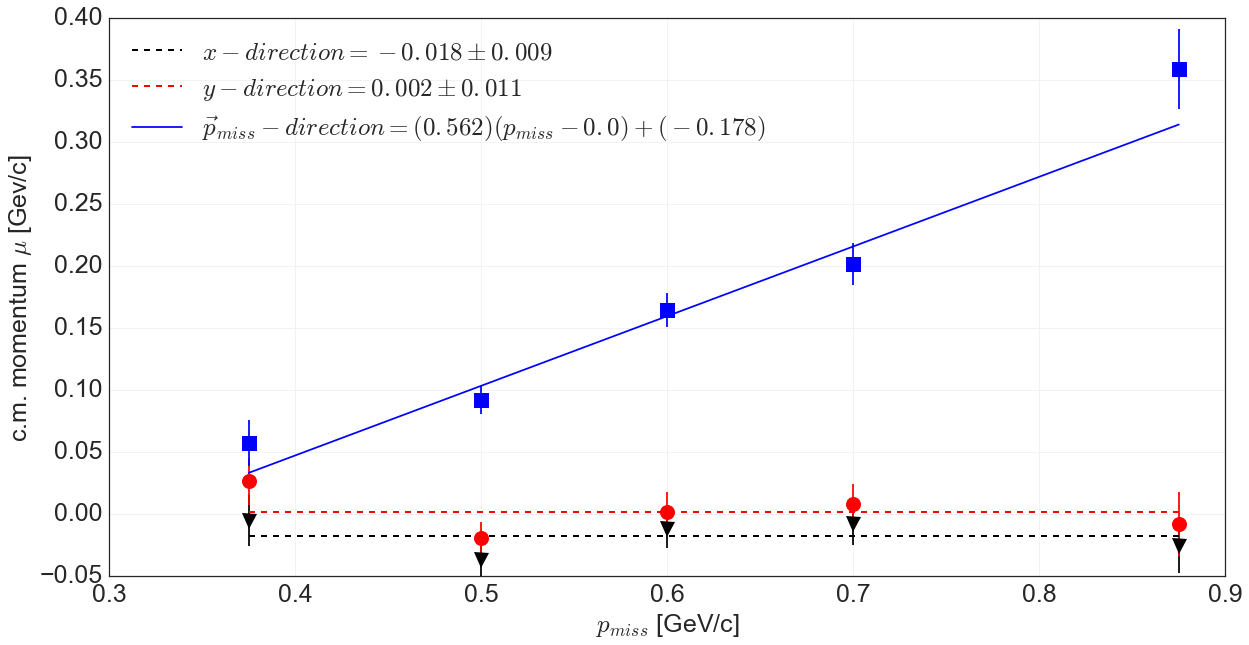

In [164]:
#no offset
fit_par_plot( data=cm_parameters,  var='mean', title='$\\mu$', weight='unweighted', do_plot_fit_pars=True )

const fit ($x-direction$) parameters:
[-0.01782276] 
 covariance:
[[  7.24364528e-05]]
const fit ($y-direction$) parameters:
[ 0.00157056] 
 covariance:
[[ 0.00012]]
linear fit ($\vec{p}_{miss}-direction$)
-----------
 parameters:
[ 0.56178162  0.15944898] 
 covariance:
[[  6.10773987e-03   2.57113796e-04]
 [  2.57113796e-04   9.94433201e-05]]


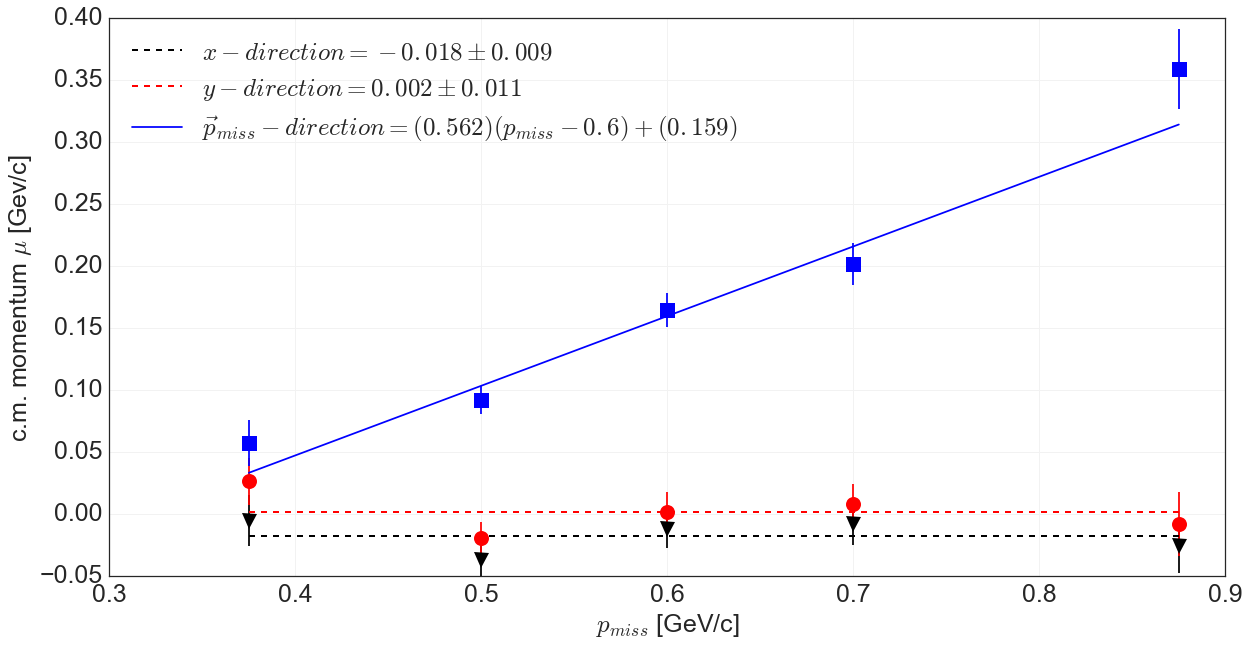

In [165]:
#with offset 0.6
fit_par_plot( data=cm_parameters,  var='mean', PmissOffset=0.6, title='$\\mu$', weight='unweighted', do_plot_fit_pars=True )

const fit ($x-direction$) parameters:
[ 0.16528952] 
 covariance:
[[  4.96894342e-05]]
const fit ($y-direction$) parameters:
[ 0.16967154] 
 covariance:
[[ 0.00014423]]
linear fit ($\vec{p}_{miss}-direction$)
-----------
 parameters:
[ 0.14392575  0.0725059 ] 
 covariance:
[[ 0.00576415 -0.00321475]
 [-0.00321475  0.00187616]]


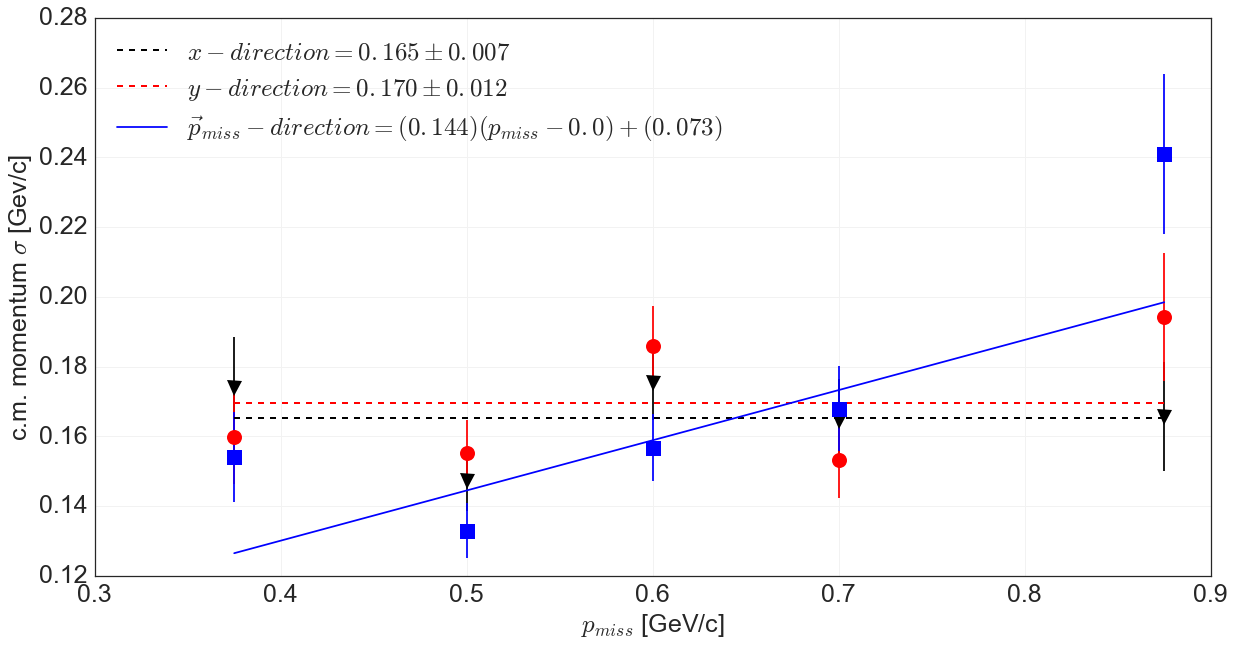

In [166]:
# sigma - no offset
fit_par_plot( data=cm_parameters, var='sigma', title='$\\sigma$', weight='unweighted', do_plot_fit_pars=True ) 

const fit ($x-direction$) parameters:
[ 0.16528952] 
 covariance:
[[  4.96894342e-05]]
const fit ($y-direction$) parameters:
[ 0.16967154] 
 covariance:
[[ 0.00014423]]
linear fit ($\vec{p}_{miss}-direction$)
-----------
 parameters:
[ 0.14392575  0.15886135] 
 covariance:
[[  5.76414597e-03   2.43737408e-04]
 [  2.43737408e-04   9.35558180e-05]]


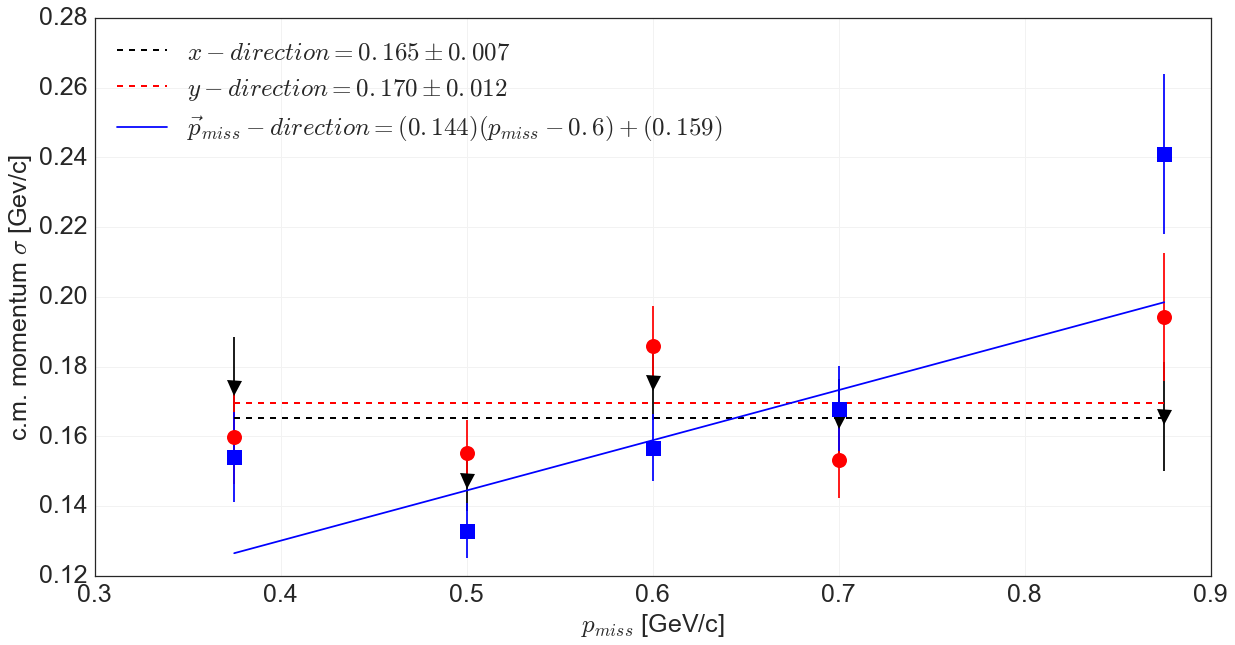

In [167]:
# sigma - with offset
fit_par_plot( data=cm_parameters, var='sigma', PmissOffset=0.6, title='$\\sigma$', weight='unweighted', do_plot_fit_pars=True ) 